# Détecter des attaques sur les vraies données (fournit par Thales Datalab)  

### Import data

In [8]:
import pandas as pd 
import numpy as np 
from pandas import Series,DataFrame
test_logs = pd.read_csv("./data/test.csv")
test_logs.shape

(102989, 14)

### Pré-traitement des données
#### Ajout des nouveaux features comme les longueurs, des symboles spéciaux et des mots spéciaux

In [9]:
import re
from sklearn.feature_extraction.text import CountVectorizer
# obtenir la longueur de lien(information)
def get_len(info_comp):
    return len(info_comp)

# obtenir des symboles spécials pour logs sql
def get_sql_char(info_comp):
    return len(re.findall("[?=\*#@%>]", info_comp, re.IGNORECASE))

# obtenir des mots spécials pour logs sql
def get_sql_word(info_comp):
    return len(re.findall("(SELECT)|(version)|(comment)|(user)|(FROM)|(mysql)|(host)|(DELET)|(name)|(MYSQL)|(WHERE)|(password)|(ORDER)",info_comp,re.IGNORECASE))

# obtenir des symboles spécials pour logs xss
def get_xss_char(info_comp):
    return len(re.findall("[<>\"\'=&{}!#\*]", info_comp, re.IGNORECASE))

# obtenir des mots spécials pour logs xss
def get_xss_word(info_comp):
    return len(re.findall("(alert)|(script)|(XSS)|(SRC=)|(xss)|(onerror)|(onload)|(BODY)|(src=)|(INPUT)|(http)|(LINK)|(url=)|(SCRIPT)",info_comp,re.IGNORECASE))

def get_password_number(info_comp):
    return len(re.findall("((?:0(?=1)|1(?=2)|2(?=3)|3(?=4)|4(?=5)|5(?=6)|6(?=7)|7(?=8)|8(?=9)|9(?=0)){2}\d)|((\d)\1{2})",info_comp,re.IGNORECASE))

def get_feature(info_comp):
    return [get_len(info_comp),get_evil_char(info_comp),get_evil_word(info_comp)]


In [10]:
f=lambda x: str(x)
test_logs['len']=test_logs['password'].apply(f).apply(get_len)
test_logs['sqlchar']=test_logs['password'].apply(f).apply(get_sql_char)
test_logs['sqlword']=test_logs['password'].apply(f).apply(get_sql_word)
test_logs['xsschar']=test_logs['password'].apply(f).apply(get_xss_char)
test_logs['xssword']=test_logs['password'].apply(f).apply(get_xss_word)
test_logs['passnumber']=test_logs['password'].apply(f).apply(get_password_number)
test_logs.head()

,Unnamed: 0,ip_address,date,hour,minute,seconds,zone,protocol,username,password,status,respsize,timed,label,len,sqlchar,sqlword,xsschar,xssword,passnumber
0,0,189.188.154.208,07/Jul/2017,12,10,0,200,GET,frank,frank,200,24478,800,0,5,0,0,0,0,0
1,1,189.183.172.77,07/Jul/2017,12,15,0,200,GET,bob,123456789,200,3243,1431,1,9,0,0,0,0,3
2,2,128.55.162.143,07/Jul/2017,12,20,0,200,GET,alice,alice,200,28222,802,0,5,0,0,0,0,0
3,3,128.147.11.33,07/Jul/2017,12,25,0,200,GET,ted,ted,200,16281,803,0,3,0,0,0,0,0
4,4,128.168.150.134,07/Jul/2017,12,30,0,200,GET,dimi,dimi,200,20261,804,0,4,0,0,0,0,0


#### Transformation de la forme de l'adresse IP

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
test_logs['ip_address'] = le.fit_transform(test_logs['ip_address'].apply(f))
test_logs.head()

,Unnamed: 0,ip_address,date,hour,minute,seconds,zone,protocol,username,password,status,respsize,timed,label,len,sqlchar,sqlword,xsschar,xssword,passnumber
0,0,88643,07/Jul/2017,12,10,0,200,GET,frank,frank,200,24478,800,0,5,0,0,0,0,0
1,1,88200,07/Jul/2017,12,15,0,200,GET,bob,123456789,200,3243,1431,1,9,0,0,0,0,3
2,2,64556,07/Jul/2017,12,20,0,200,GET,alice,alice,200,28222,802,0,5,0,0,0,0,0
3,3,16722,07/Jul/2017,12,25,0,200,GET,ted,ted,200,16281,803,0,3,0,0,0,0,0
4,4,23870,07/Jul/2017,12,30,0,200,GET,dimi,dimi,200,20261,804,0,4,0,0,0,0,0


In [12]:
del test_logs[test_logs.columns[0]]

#### Remplacement des données null au 0

In [13]:
def replace(resp):
    if resp == '-':
        resp = 0
    elif (resp == resp) == False:
        resp = 0
    return (resp)
test_logs['respsize']=test_logs['respsize'].apply(replace)
test_logs['timed']=test_logs['timed'].apply(replace)
test_logs['status']=test_logs['status'].apply(replace)

#### Fonctions pour évaluer la performance

In [14]:
from sklearn import metrics
def do_metrics(y_test,y_pred):
    print ("metrics.confusion_matrix:")
    print (metrics.confusion_matrix(y_test, y_pred))
    print ("metrics.accuracy_score:")
    print (metrics.accuracy_score(y_test, y_pred))
    print ("metrics.precision_score:")
    print (metrics.precision_score(y_test, y_pred))
    print ("metrics.recall_score:")
    print (metrics.recall_score(y_test, y_pred))
    print ("metrics.f1_score:")
    print (metrics.f1_score(y_test,y_pred))

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_cm(cm, labels):
    
    # Compute percentanges
    percent = (cm*100.0)/np.array(np.matrix(cm.sum(axis=1)).T)  # Derp, I'm sure there's a better way
    
    print ('Confusion Matrix Stats')
    for i, label_i in enumerate(labels):
        for j, label_j in enumerate(labels):
            print ("%s/%s: %.2f%% (%d/%d)" % (label_i, label_j, (percent[i][j]), cm[i][j], cm[i].sum()))

    # Show confusion matrix
    # Thanks kermit666 from stackoverflow :)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.grid(b=False)
    cax = ax.matshow(percent, cmap='Greens')
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
def plot_roc(model,y_test,y_pred):
    # Compute ROC curve and ROC area for each class  
    fpr,tpr,threshold = roc_curve(y_test, y_pred) ###True positive和false positive  
    roc_auc = auc(fpr,tpr) ###auc 

    plt.figure()  
    lw = 2  
    plt.figure(figsize=(5,5))  
    plt.plot(fpr, tpr, color='darkorange',  
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')  
    plt.xlim([0.0, 1.0])  
    plt.ylim([0.0, 1.05])  
    plt.xlabel('False Positive Rate')  
    plt.ylabel('True Positive Rate')  
    plt.title('Receiver operating characteristic example')  
    plt.legend(loc="lower right")  
    plt.show()  

### Feature Engineering

#### Nettoyage des features manuellement

In [17]:
features = list(test_logs.columns[[0,2,3,4,9,10,11,13,14,15,16,17,18]])
X = test_logs[features]
X.head()

,ip_address,hour,minute,seconds,status,respsize,timed,len,sqlchar,sqlword,xsschar,xssword,passnumber
0,88643,12,10,0,200,24478,800,5,0,0,0,0,0
1,88200,12,15,0,200,3243,1431,9,0,0,0,0,3
2,64556,12,20,0,200,28222,802,5,0,0,0,0,0
3,16722,12,25,0,200,16281,803,3,0,0,0,0,0
4,23870,12,30,0,200,20261,804,4,0,0,0,0,0


In [18]:
def transint(x):
    x=int(x)
    return(x)
X['status']=X['status'].apply(transint)
X['respsize']=X['respsize'].apply(transint)
X['timed']=X['timed'].apply(transint)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Nettoyage des labels

In [21]:
y = test_logs['label']

#### Séparation des données aux train set(70%) et test set(30%)

In [22]:
from sklearn import cross_validation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [24]:
# add "IP count" feature
list_ip_train=np.array(X_train['ip_address']).tolist()
def count_ip_train(x):
    ipcount=list_ip_train.count(x)
    return(ipcount)
X_train['ipcount']=X_train['ip_address'].apply(count_ip_train)
list_ip_test=np.array(X_test['ip_address']).tolist()
def count_ip_test(x):
    ipcount=list_ip_test.count(x)
    return(ipcount)
X_test['ipcount']=X_test['ip_address'].apply(count_ip_test)

D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
X_train.head(2)

,ip_address,hour,minute,seconds,status,respsize,timed,len,sqlchar,sqlword,xsschar,xssword,passnumber,ipcount
24825,94715,21,40,0,200,28220,736,6,0,0,0,0,0,1
79636,54454,19,40,0,200,9650,711,4,0,0,0,0,0,1


#### Choix des features

In [26]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf_f = ExtraTreesClassifier()
clf_f = clf_f.fit(X_train, y_train)
clf_f.feature_importances_

array([1.85096017e-01, 7.08635527e-03, 9.48860291e-02, 0.00000000e+00,
       0.00000000e+00, 8.28747325e-03, 3.10021923e-01, 2.26113050e-01,
       0.00000000e+00, 1.60654342e-02, 0.00000000e+00, 0.00000000e+00,
       1.52340402e-01, 1.03316842e-04])

In [27]:
model = SelectFromModel(clf_f, prefit=True)
X_train_new = model.transform(X_train)
X_test_new = model.transform(X_test)

D:\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:93: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


In [28]:
X_train_new[0]

array([94715,    40,   736,     6,     0], dtype=int64)

### Détection des attaques en utilisant RandomForest

metrics.confusion_matrix:
[[27441     0]
 [    1  3455]]
metrics.accuracy_score:
0.9999676343981616
metrics.precision_score:
1.0
metrics.recall_score:
0.9997106481481481
metrics.f1_score:
0.9998553031399219
Confusion Matrix Stats
no attaque/no attaque: 100.00% (27441/27441)
no attaque/attaque: 0.00% (0/27441)
attaque/no attaque: 0.03% (1/3456)
attaque/attaque: 99.97% (3455/3456)


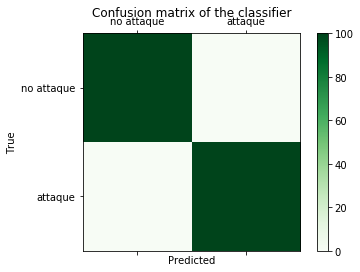

In [30]:
from sklearn.ensemble import RandomForestClassifier
# classifier
clf_rf = RandomForestClassifier(n_estimators= 170, max_depth=11, min_samples_split=2,
                                  min_samples_leaf=1)
# training
clf_rf = clf_rf.fit(X_train_new, y_train)
# classification
y_pred = clf_rf.predict(X_test_new)
# confusion matrix
do_metrics(y_test,y_pred)
labels = ['no attaque', 'attaque']
cm = metrics.confusion_matrix(y_test, y_pred)
plot_cm(cm, labels)